## Neural Network models - Leave One Participant Out CV to predict properties using 3 subwindows

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import random
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import torch.optim as optim



In [2]:
# Initialise the random state
#num = random.randint(1, 500)
num = 58
torch.manual_seed(num)
np.random.seed(num)
print(f"The generated random seed is {num}") #347

The generated random seed is 58


### Load data

In [3]:
path = "/Users/niharawarawita/Desktop/MSc Project/Data and code/complete_dataset_3subwindows.csv"
df = pd.read_csv(path)
df.head(10)

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,subwindow_start_time,subwindow_end_time,max_ch1_Hand0,max_ch2_Hand0,max_ch3_Hand0,max_ch4_Hand0,max_ch5_Hand0,max_ch6_Hand0,max_ch7_Hand0,max_ch8_Hand0,mean_ch1_Hand0,mean_ch2_Hand0,mean_ch3_Hand0,mean_ch4_Hand0,mean_ch5_Hand0,mean_ch6_Hand0,mean_ch7_Hand0,mean_ch8_Hand0,std_ch1_Hand0,std_ch2_Hand0,std_ch3_Hand0,std_ch4_Hand0,std_ch5_Hand0,std_ch6_Hand0,std_ch7_Hand0,std_ch8_Hand0,max_ch1_Hand1,max_ch2_Hand1,max_ch3_Hand1,max_ch4_Hand1,max_ch5_Hand1,max_ch6_Hand1,max_ch7_Hand1,max_ch8_Hand1,mean_ch1_Hand1,mean_ch2_Hand1,mean_ch3_Hand1,mean_ch4_Hand1,mean_ch5_Hand1,mean_ch6_Hand1,mean_ch7_Hand1,mean_ch8_Hand1,std_ch1_Hand1,std_ch2_Hand1,std_ch3_Hand1,std_ch4_Hand1,std_ch5_Hand1,std_ch6_Hand1,std_ch7_Hand1,std_ch8_Hand1,max_Ax_Hand0,max_Ay_Hand0,max_Az_Hand0,max_Vx_Hand0,max_Vy_Hand0,max_Vz_Hand0,max_Jx_Hand0,max_Jy_Hand0,max_Jz_Hand0,mean_Ax_Hand0,mean_Ay_Hand0,mean_Az_Hand0,mean_Vx_Hand0,mean_Vy_Hand0,mean_Vz_Hand0,mean_Jx_Hand0,mean_Jy_Hand0,mean_Jz_Hand0,std_Ax_Hand0,std_Ay_Hand0,std_Az_Hand0,std_Vx_Hand0,std_Vy_Hand0,std_Vz_Hand0,std_Jx_Hand0,std_Jy_Hand0,std_Jz_Hand0,max_Ax_Hand1,max_Ay_Hand1,max_Az_Hand1,max_Vx_Hand1,max_Vy_Hand1,max_Vz_Hand1,max_Jx_Hand1,max_Jy_Hand1,max_Jz_Hand1,mean_Ax_Hand1,mean_Ay_Hand1,mean_Az_Hand1,mean_Vx_Hand1,mean_Vy_Hand1,mean_Vz_Hand1,mean_Jx_Hand1,mean_Jy_Hand1,mean_Jz_Hand1,std_Ax_Hand1,std_Ay_Hand1,std_Az_Hand1,std_Vx_Hand1,std_Vy_Hand1,std_Vz_Hand1,std_Jx_Hand1,std_Jy_Hand1,std_Jz_Hand1,max_w_Hand0,max_x_Hand0,max_y_Hand0,max_z_Hand0,max_AVx_Hand0,max_AVy_Hand0,max_AVz_Hand0,max_AAx_Hand0,max_AAy_Hand0,max_AAz_Hand0,max_AJx_Hand0,max_AJy_Hand0,max_AJz_Hand0,mean_w_Hand0,mean_x_Hand0,mean_y_Hand0,mean_z_Hand0,mean_AVx_Hand0,mean_AVy_Hand0,mean_AVz_Hand0,mean_AAx_Hand0,mean_AAy_Hand0,mean_AAz_Hand0,mean_AJx_Hand0,mean_AJy_Hand0,mean_AJz_Hand0,std_w_Hand0,std_x_Hand0,std_y_Hand0,std_z_Hand0,std_AVx_Hand0,std_AVy_Hand0,std_AVz_Hand0,std_AAx_Hand0,std_AAy_Hand0,std_AAz_Hand0,std_AJx_Hand0,std_AJy_Hand0,std_AJz_Hand0,max_w_Hand1,max_x_Hand1,max_y_Hand1,max_z_Hand1,max_AVx_Hand1,max_AVy_Hand1,max_AVz_Hand1,max_AAx_Hand1,max_AAy_Hand1,max_AAz_Hand1,max_AJx_Hand1,max_AJy_Hand1,max_AJz_Hand1,mean_w_Hand1,mean_x_Hand1,mean_y_Hand1,mean_z_Hand1,mean_AVx_Hand1,mean_AVy_Hand1,mean_AVz_Hand1,mean_AAx_Hand1,mean_AAy_Hand1,mean_AAz_Hand1,mean_AJx_Hand1,mean_AJy_Hand1,mean_AJz_Hand1,std_w_Hand1,std_x_Hand1,std_y_Hand1,std_z_Hand1,std_AVx_Hand1,std_AVy_Hand1,std_AVz_Hand1,std_AAx_Hand1,std_AAy_Hand1,std_AAz_Hand1,std_AJx_Hand1,std_AJy_Hand1,std_AJz_Hand1
0,7,14,3,smoothness,1,3,medium,2,1,2021-08-05 13:21:31.481,2021-08-05 13:21:32.468,0.504132,0.620513,0.675978,0.500000,0.759036,0.652406,0.76250,0.666667,0.497498,0.612780,0.665895,0.492285,0.718526,0.636907,0.748853,0.660720,0.002329,0.002760,0.003011,0.002201,0.006194,0.004289,0.003634,0.002595,0.508197,0.929578,0.757225,0.730159,0.497959,0.995918,0.663366,0.580645,0.497102,0.848495,0.692072,0.634859,0.491574,0.511567,0.596728,0.558018,0.003056,0.009851,0.011220,0.016046,0.002283,0.125342,0.014496,0.005100,-0.850708,-0.068771,0.490311,0.000525,0.000406,0.000903,1.269531,1.220703,2.258301,-0.863979,-0.089162,0.468123,-4.589844e-06,1.483398e-05,-1.191406e-05,-0.010928,-0.052313,0.060087,0.006994,0.008424,0.010178,0.000201,0.000180,0.000270,0.599364,0.630856,0.794158,1.023270,0.042786,-0.178879,0.001218,0.001529,0.001429,4.089355,5.468750,3.271484,0.970242,-0.011443,-0.239064,-3.020508e-05,-8.115234e-06,0.000065,0.061211,0.036287,-0.170119,0.017187,0.014988,0.034359,0.000440,0.000417,0.000641,1.262790,1.374306,1.977670,0.179352,0.488418,0.160615,-0.840857,0.133141,0.061469,0.117029,4.332320,2.887801,19.812834,554.574503,316.450316,1338.775861,0.171550,0.486515,0.155002,-0.842509,-0.002358,-0.006487,-0.037808,-0.069210,0.040128,0.213198,-18.896953,-5.997847,29.264918,0.004033,0.001122,0.003172,0.000812,0.034035,0.027288,0.100030,1.808784,1.34

In [4]:
# Remove enjoyment as we are only considering physical properties
print(df.shape)
physical_df = df[df.property_name!='enjoyment']
physical_df.shape

(1512, 191)


(1260, 191)

In [5]:
physical_df.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,subwindow_start_time,subwindow_end_time,max_ch1_Hand0,max_ch2_Hand0,max_ch3_Hand0,max_ch4_Hand0,max_ch5_Hand0,max_ch6_Hand0,max_ch7_Hand0,max_ch8_Hand0,mean_ch1_Hand0,mean_ch2_Hand0,mean_ch3_Hand0,mean_ch4_Hand0,mean_ch5_Hand0,mean_ch6_Hand0,mean_ch7_Hand0,mean_ch8_Hand0,std_ch1_Hand0,std_ch2_Hand0,std_ch3_Hand0,std_ch4_Hand0,std_ch5_Hand0,std_ch6_Hand0,std_ch7_Hand0,std_ch8_Hand0,max_ch1_Hand1,max_ch2_Hand1,max_ch3_Hand1,max_ch4_Hand1,max_ch5_Hand1,max_ch6_Hand1,max_ch7_Hand1,max_ch8_Hand1,mean_ch1_Hand1,mean_ch2_Hand1,mean_ch3_Hand1,mean_ch4_Hand1,mean_ch5_Hand1,mean_ch6_Hand1,mean_ch7_Hand1,mean_ch8_Hand1,std_ch1_Hand1,std_ch2_Hand1,std_ch3_Hand1,std_ch4_Hand1,std_ch5_Hand1,std_ch6_Hand1,std_ch7_Hand1,std_ch8_Hand1,max_Ax_Hand0,max_Ay_Hand0,max_Az_Hand0,max_Vx_Hand0,max_Vy_Hand0,max_Vz_Hand0,max_Jx_Hand0,max_Jy_Hand0,max_Jz_Hand0,mean_Ax_Hand0,mean_Ay_Hand0,mean_Az_Hand0,mean_Vx_Hand0,mean_Vy_Hand0,mean_Vz_Hand0,mean_Jx_Hand0,mean_Jy_Hand0,mean_Jz_Hand0,std_Ax_Hand0,std_Ay_Hand0,std_Az_Hand0,std_Vx_Hand0,std_Vy_Hand0,std_Vz_Hand0,std_Jx_Hand0,std_Jy_Hand0,std_Jz_Hand0,max_Ax_Hand1,max_Ay_Hand1,max_Az_Hand1,max_Vx_Hand1,max_Vy_Hand1,max_Vz_Hand1,max_Jx_Hand1,max_Jy_Hand1,max_Jz_Hand1,mean_Ax_Hand1,mean_Ay_Hand1,mean_Az_Hand1,mean_Vx_Hand1,mean_Vy_Hand1,mean_Vz_Hand1,mean_Jx_Hand1,mean_Jy_Hand1,mean_Jz_Hand1,std_Ax_Hand1,std_Ay_Hand1,std_Az_Hand1,std_Vx_Hand1,std_Vy_Hand1,std_Vz_Hand1,std_Jx_Hand1,std_Jy_Hand1,std_Jz_Hand1,max_w_Hand0,max_x_Hand0,max_y_Hand0,max_z_Hand0,max_AVx_Hand0,max_AVy_Hand0,max_AVz_Hand0,max_AAx_Hand0,max_AAy_Hand0,max_AAz_Hand0,max_AJx_Hand0,max_AJy_Hand0,max_AJz_Hand0,mean_w_Hand0,mean_x_Hand0,mean_y_Hand0,mean_z_Hand0,mean_AVx_Hand0,mean_AVy_Hand0,mean_AVz_Hand0,mean_AAx_Hand0,mean_AAy_Hand0,mean_AAz_Hand0,mean_AJx_Hand0,mean_AJy_Hand0,mean_AJz_Hand0,std_w_Hand0,std_x_Hand0,std_y_Hand0,std_z_Hand0,std_AVx_Hand0,std_AVy_Hand0,std_AVz_Hand0,std_AAx_Hand0,std_AAy_Hand0,std_AAz_Hand0,std_AJx_Hand0,std_AJy_Hand0,std_AJz_Hand0,max_w_Hand1,max_x_Hand1,max_y_Hand1,max_z_Hand1,max_AVx_Hand1,max_AVy_Hand1,max_AVz_Hand1,max_AAx_Hand1,max_AAy_Hand1,max_AAz_Hand1,max_AJx_Hand1,max_AJy_Hand1,max_AJz_Hand1,mean_w_Hand1,mean_x_Hand1,mean_y_Hand1,mean_z_Hand1,mean_AVx_Hand1,mean_AVy_Hand1,mean_AVz_Hand1,mean_AAx_Hand1,mean_AAy_Hand1,mean_AAz_Hand1,mean_AJx_Hand1,mean_AJy_Hand1,mean_AJz_Hand1,std_w_Hand1,std_x_Hand1,std_y_Hand1,std_z_Hand1,std_AVx_Hand1,std_AVy_Hand1,std_AVz_Hand1,std_AAx_Hand1,std_AAy_Hand1,std_AAz_Hand1,std_AJx_Hand1,std_AJy_Hand1,std_AJz_Hand1
0,7,14,3,smoothness,1,3,medium,2,1,2021-08-05 13:21:31.481,2021-08-05 13:21:32.468,0.504132,0.620513,0.675978,0.500000,0.759036,0.652406,0.76250,0.666667,0.497498,0.612780,0.665895,0.492285,0.718526,0.636907,0.748853,0.660720,0.002329,0.002760,0.003011,0.002201,0.006194,0.004289,0.003634,0.002595,0.508197,0.929578,0.757225,0.730159,0.497959,0.995918,0.663366,0.580645,0.497102,0.848495,0.692072,0.634859,0.491574,0.511567,0.596728,0.558018,0.003056,0.009851,0.011220,0.016046,0.002283,0.125342,0.014496,0.005100,-0.850708,-0.068771,0.490311,0.000525,0.000406,0.000903,1.269531,1.220703,2.258301,-0.863979,-0.089162,0.468123,-0.000005,1.483398e-05,-1.191406e-05,-0.010928,-0.052313,0.060087,0.006994,0.008424,0.010178,0.000201,0.000180,0.000270,0.599364,0.630856,0.794158,1.023270,0.042786,-0.178879,0.001218,0.001529,0.001429,4.089355,5.468750,3.271484,0.970242,-0.011443,-0.239064,-0.000030,-8.115234e-06,0.000065,0.061211,0.036287,-0.170119,0.017187,0.014988,0.034359,0.000440,0.000417,0.000641,1.262790,1.374306,1.977670,0.179352,0.488418,0.160615,-0.840857,0.133141,0.061469,0.117029,4.332320,2.887801,19.812834,554.574503,316.450316,1338.775861,0.171550,0.486515,0.155002,-0.842509,-0.002358,-0.006487,-0.037808,-0.069210,0.040128,0.213198,-18.896953,-5.997847,29.264918,0.004033,0.001122,0.003172,0.000812,0.034035,0.027288,0.100030,1.808784,1.349269,6.5

### Normalise the data

In [6]:
starting_index = 11
# Obtain a df of features
features_df = physical_df.iloc[:,starting_index:]
features_df.head()


,max_ch1_Hand0,max_ch2_Hand0,max_ch3_Hand0,max_ch4_Hand0,max_ch5_Hand0,max_ch6_Hand0,max_ch7_Hand0,max_ch8_Hand0,mean_ch1_Hand0,mean_ch2_Hand0,mean_ch3_Hand0,mean_ch4_Hand0,mean_ch5_Hand0,mean_ch6_Hand0,mean_ch7_Hand0,mean_ch8_Hand0,std_ch1_Hand0,std_ch2_Hand0,std_ch3_Hand0,std_ch4_Hand0,std_ch5_Hand0,std_ch6_Hand0,std_ch7_Hand0,std_ch8_Hand0,max_ch1_Hand1,max_ch2_Hand1,max_ch3_Hand1,max_ch4_Hand1,max_ch5_Hand1,max_ch6_Hand1,max_ch7_Hand1,max_ch8_Hand1,mean_ch1_Hand1,mean_ch2_Hand1,mean_ch3_Hand1,mean_ch4_Hand1,mean_ch5_Hand1,mean_ch6_Hand1,mean_ch7_Hand1,mean_ch8_Hand1,std_ch1_Hand1,std_ch2_Hand1,std_ch3_Hand1,std_ch4_Hand1,std_ch5_Hand1,std_ch6_Hand1,std_ch7_Hand1,std_ch8_Hand1,max_Ax_Hand0,max_Ay_Hand0,max_Az_Hand0,max_Vx_Hand0,max_Vy_Hand0,max_Vz_Hand0,max_Jx_Hand0,max_Jy_Hand0,max_Jz_Hand0,mean_Ax_Hand0,mean_Ay_Hand0,mean_Az_Hand0,mean_Vx_Hand0,mean_Vy_Hand0,mean_Vz_Hand0,mean_Jx_Hand0,mean_Jy_Hand0,mean_Jz_Hand0,std_Ax_Hand0,std_Ay_Hand0,std_Az_Hand0,std_Vx_Hand0,std_Vy_Hand0,std_Vz_Hand0,std_Jx_Hand0,std_Jy_Hand0,std_Jz_Hand0,max_Ax_Hand1,max_Ay_Hand1,max_Az_Hand1,max_Vx_Hand1,max_Vy_Hand1,max_Vz_Hand1,max_Jx_Hand1,max_Jy_Hand1,max_Jz_Hand1,mean_Ax_Hand1,mean_Ay_Hand1,mean_Az_Hand1,mean_Vx_Hand1,mean_Vy_Hand1,mean_Vz_Hand1,mean_Jx_Hand1,mean_Jy_Hand1,mean_Jz_Hand1,std_Ax_Hand1,std_Ay_Hand1,std_Az_Hand1,std_Vx_Hand1,std_Vy_Hand1,std_Vz_Hand1,std_Jx_Hand1,std_Jy_Hand1,std_Jz_Hand1,max_w_Hand0,max_x_Hand0,max_y_Hand0,max_z_Hand0,max_AVx_Hand0,max_AVy_Hand0,max_AVz_Hand0,max_AAx_Hand0,max_AAy_Hand0,max_AAz_Hand0,max_AJx_Hand0,max_AJy_Hand0,max_AJz_Hand0,mean_w_Hand0,mean_x_Hand0,mean_y_Hand0,mean_z_Hand0,mean_AVx_Hand0,mean_AVy_Hand0,mean_AVz_Hand0,mean_AAx_Hand0,mean_AAy_Hand0,mean_AAz_Hand0,mean_AJx_Hand0,mean_AJy_Hand0,mean_AJz_Hand0,std_w_Hand0,std_x_Hand0,std_y_Hand0,std_z_Hand0,std_AVx_Hand0,std_AVy_Hand0,std_AVz_Hand0,std_AAx_Hand0,std_AAy_Hand0,std_AAz_Hand0,std_AJx_Hand0,std_AJy_Hand0,std_AJz_Hand0,max_w_Hand1,max_x_Hand1,max_y_Hand1,max_z_Hand1,max_AVx_Hand1,max_AVy_Hand1,max_AVz_Hand1,max_AAx_Hand1,max_AAy_Hand1,max_AAz_Hand1,max_AJx_Hand1,max_AJy_Hand1,max_AJz_Hand1,mean_w_Hand1,mean_x_Hand1,mean_y_Hand1,mean_z_Hand1,mean_AVx_Hand1,mean_AVy_Hand1,mean_AVz_Hand1,mean_AAx_Hand1,mean_AAy_Hand1,mean_AAz_Hand1,mean_AJx_Hand1,mean_AJy_Hand1,mean_AJz_Hand1,std_w_Hand1,std_x_Hand1,std_y_Hand1,std_z_Hand1,std_AVx_Hand1,std_AVy_Hand1,std_AVz_Hand1,std_AAx_Hand1,std_AAy_Hand1,std_AAz_Hand1,std_AJx_Hand1,std_AJy_Hand1,std_AJz_Hand1
0,0.504132,0.620513,0.675978,0.500000,0.759036,0.652406,0.76250,0.666667,0.497498,0.612780,0.665895,0.492285,0.718526,0.636907,0.748853,0.660720,0.002329,0.002760,0.003011,0.002201,0.006194,0.004289,0.003634,0.002595,0.508197,0.929578,0.757225,0.730159,0.497959,0.995918,0.663366,0.580645,0.497102,0.848495,0.692072,0.634859,0.491574,0.511567,0.596728,0.558018,0.003056,0.009851,0.011220,0.016046,0.002283,0.125342,0.014496,0.005100,-0.850708,-0.068771,0.490311,0.000525,0.000406,0.000903,1.269531,1.220703,2.258301,-0.863979,-0.089162,0.468123,-0.000005,1.483398e-05,-1.191406e-05,-0.010928,-0.052313,0.060087,0.006994,0.008424,0.010178,0.000201,0.000180,0.000270,0.599364,0.630856,0.794158,1.023270,0.042786,-0.178879,0.001218,0.001529,0.001429,4.089355,5.468750,3.271484,0.970242,-0.011443,-0.239064,-0.000030,-8.115234e-06,0.000065,0.061211,0.036287,-0.170119,0.017187,0.014988,0.034359,0.000440,0.000417,0.000641,1.262790,1.374306,1.977670,0.179352,0.488418,0.160615,-0.840857,0.133141,0.061469,0.117029,4.332320,2.887801,19.812834,554.574503,316.450316,1338.775861,0.171550,0.486515,0.155002,-0.842509,-0.002358,-0.006487,-0.037808,-0.069210,0.040128,0.213198,-18.896953,-5.997847,29.264918,0.004033,0.001122,0.003172,0.000812,0.034035,0.027288,0.100030,1.808784,1.349269,6.515867,214.502864,135.316892,572.754308,0.618680,-0.175326,-0.753378,-0.128901,0.215491,0.583907,0.275227,21.603607,56.450019,29.424453,2797.763022,9050.317251,2366.953044,0.602964,-0.177295,-0.766545,-0.131596,-0.011132,-0.035192,-0.000290,

In [7]:
normalised_features_df = features_df.copy()
print(normalised_features_df.shape)

(1260, 180)


In [8]:
# create scaler
scaler = MinMaxScaler(feature_range=(-1,1)) # As this is the range of the activation function - tanh

# fit scaler and apply transform
normalised_features_df[normalised_features_df.columns] = scaler.fit_transform(features_df[features_df.columns])
normalised_features_df.shape

(1260, 180)

In [9]:
df_info = physical_df.iloc[:, :starting_index]
df_info.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,subwindow_start_time,subwindow_end_time
0,7,14,3,smoothness,1,3,medium,2,1,2021-08-05 13:21:31.481,2021-08-05 13:21:32.468
1,7,14,3,smoothness,1,3,medium,2,2,2021-08-05 13:21:32.495,2021-08-05 13:21:33.464
2,7,14,3,smoothness,1,3,medium,2,3,2021-08-05 13:21:33.513,2021-08-05 13:21:46.475
3,7,14,4,thickness,2,5,medium,2,1,2021-08-05 13:22:02.060,2021-08-05 13:22:03.029
4,7,14,4,thickness,2,5,medium,2,2,2021-08-05 13:22:03.061,2021-08-05 13:22:04.047


In [10]:
normalised_df = pd.concat([df_info,normalised_features_df], axis=1)
normalised_df.shape

(1260, 191)

In [11]:
normalised_df.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,subwindow_start_time,subwindow_end_time,max_ch1_Hand0,max_ch2_Hand0,max_ch3_Hand0,max_ch4_Hand0,max_ch5_Hand0,max_ch6_Hand0,max_ch7_Hand0,max_ch8_Hand0,mean_ch1_Hand0,mean_ch2_Hand0,mean_ch3_Hand0,mean_ch4_Hand0,mean_ch5_Hand0,mean_ch6_Hand0,mean_ch7_Hand0,mean_ch8_Hand0,std_ch1_Hand0,std_ch2_Hand0,std_ch3_Hand0,std_ch4_Hand0,std_ch5_Hand0,std_ch6_Hand0,std_ch7_Hand0,std_ch8_Hand0,max_ch1_Hand1,max_ch2_Hand1,max_ch3_Hand1,max_ch4_Hand1,max_ch5_Hand1,max_ch6_Hand1,max_ch7_Hand1,max_ch8_Hand1,mean_ch1_Hand1,mean_ch2_Hand1,mean_ch3_Hand1,mean_ch4_Hand1,mean_ch5_Hand1,mean_ch6_Hand1,mean_ch7_Hand1,mean_ch8_Hand1,std_ch1_Hand1,std_ch2_Hand1,std_ch3_Hand1,std_ch4_Hand1,std_ch5_Hand1,std_ch6_Hand1,std_ch7_Hand1,std_ch8_Hand1,max_Ax_Hand0,max_Ay_Hand0,max_Az_Hand0,max_Vx_Hand0,max_Vy_Hand0,max_Vz_Hand0,max_Jx_Hand0,max_Jy_Hand0,max_Jz_Hand0,mean_Ax_Hand0,mean_Ay_Hand0,mean_Az_Hand0,mean_Vx_Hand0,mean_Vy_Hand0,mean_Vz_Hand0,mean_Jx_Hand0,mean_Jy_Hand0,mean_Jz_Hand0,std_Ax_Hand0,std_Ay_Hand0,std_Az_Hand0,std_Vx_Hand0,std_Vy_Hand0,std_Vz_Hand0,std_Jx_Hand0,std_Jy_Hand0,std_Jz_Hand0,max_Ax_Hand1,max_Ay_Hand1,max_Az_Hand1,max_Vx_Hand1,max_Vy_Hand1,max_Vz_Hand1,max_Jx_Hand1,max_Jy_Hand1,max_Jz_Hand1,mean_Ax_Hand1,mean_Ay_Hand1,mean_Az_Hand1,mean_Vx_Hand1,mean_Vy_Hand1,mean_Vz_Hand1,mean_Jx_Hand1,mean_Jy_Hand1,mean_Jz_Hand1,std_Ax_Hand1,std_Ay_Hand1,std_Az_Hand1,std_Vx_Hand1,std_Vy_Hand1,std_Vz_Hand1,std_Jx_Hand1,std_Jy_Hand1,std_Jz_Hand1,max_w_Hand0,max_x_Hand0,max_y_Hand0,max_z_Hand0,max_AVx_Hand0,max_AVy_Hand0,max_AVz_Hand0,max_AAx_Hand0,max_AAy_Hand0,max_AAz_Hand0,max_AJx_Hand0,max_AJy_Hand0,max_AJz_Hand0,mean_w_Hand0,mean_x_Hand0,mean_y_Hand0,mean_z_Hand0,mean_AVx_Hand0,mean_AVy_Hand0,mean_AVz_Hand0,mean_AAx_Hand0,mean_AAy_Hand0,mean_AAz_Hand0,mean_AJx_Hand0,mean_AJy_Hand0,mean_AJz_Hand0,std_w_Hand0,std_x_Hand0,std_y_Hand0,std_z_Hand0,std_AVx_Hand0,std_AVy_Hand0,std_AVz_Hand0,std_AAx_Hand0,std_AAy_Hand0,std_AAz_Hand0,std_AJx_Hand0,std_AJy_Hand0,std_AJz_Hand0,max_w_Hand1,max_x_Hand1,max_y_Hand1,max_z_Hand1,max_AVx_Hand1,max_AVy_Hand1,max_AVz_Hand1,max_AAx_Hand1,max_AAy_Hand1,max_AAz_Hand1,max_AJx_Hand1,max_AJy_Hand1,max_AJz_Hand1,mean_w_Hand1,mean_x_Hand1,mean_y_Hand1,mean_z_Hand1,mean_AVx_Hand1,mean_AVy_Hand1,mean_AVz_Hand1,mean_AAx_Hand1,mean_AAy_Hand1,mean_AAz_Hand1,mean_AJx_Hand1,mean_AJy_Hand1,mean_AJz_Hand1,std_w_Hand1,std_x_Hand1,std_y_Hand1,std_z_Hand1,std_AVx_Hand1,std_AVy_Hand1,std_AVz_Hand1,std_AAx_Hand1,std_AAy_Hand1,std_AAz_Hand1,std_AJx_Hand1,std_AJy_Hand1,std_AJz_Hand1
0,7,14,3,smoothness,1,3,medium,2,1,2021-08-05 13:21:31.481,2021-08-05 13:21:32.468,0.008264,0.241026,0.351956,0.000000,0.518072,0.304812,0.5250,0.333334,0.106673,0.460704,0.603821,0.332895,0.988182,0.603340,0.956492,0.570180,-0.985256,-0.955814,-0.949743,-0.982661,-0.964160,-0.961455,-0.967675,-0.963391,0.016394,0.859156,0.514450,0.460318,-0.004082,0.991836,0.326732,0.161290,0.258945,0.997200,0.751344,0.701532,0.295330,0.458744,0.440816,0.298715,-0.960808,-0.884621,-0.614884,-0.628047,-0.987794,-0.038630,-0.536748,-0.927903,-0.906266,-0.475236,-0.243318,-0.999931,-0.992149,-0.989218,-0.991878,-0.989967,-0.991597,-0.855731,-0.090755,0.383566,-0.933074,0.811927,0.982952,0.254368,-0.403098,-0.049889,-0.980355,-0.978590,-0.971579,-0.999582,-0.998769,-0.999741,-0.970096,-0.969547,-0.959107,-0.008904,-0.539589,-0.799247,-0.999770,-0.999676,-0.999829,-0.969993,-0.964493,-0.964812,0.940450,-0.149387,-0.560164,-0.948797,-0.672082,-0.517004,-0.000298,0.091853,-0.352547,-0.951443,-0.968661,-0.916396,-0.998678,-0.998612,-0.998779,-0.955445,-0.952792,-0.872132,0.116197,0.534686,0.133971,-0.884440,-0.988810,-0.997018,-0.994655,-0.994749,-0.998699,-0.991300,-0.998211,-0.999578,-0.998635,0.112488,0.552396,0.205140,-0.884270,0.136416,-0.003829,0.514555,0.222445,-0.732359,-0.494693,-0.375758,-0.409868,-0.693223,-0.953892,-0.989748,-0.973892,-0.991389,-0.9814

### Create X and y data

In [12]:
def create_X_2d(df, features_starting_idx):
    
    X_2d = df.iloc[:,features_starting_idx:].values
    
    X_tensor_2d = torch.Tensor(X_2d)    
    return X_tensor_2d



In [13]:
def create_y_train_for_2d_X(df, predicting_feature = 'property_id', output_as_tensor='Yes'):
    # CreatE an instance of a one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Perform one-hot encoding on the specified column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df[[predicting_feature]]).toarray())
    
    # Convert to a numpy array
    y_train = encoder_df.to_numpy()
    
    if output_as_tensor == 'Yes':
        # Convert to a tensor
        y_train = torch.Tensor(y_train)

    return y_train



In [14]:
def create_y_test_for_2d_X(df, predicting_feature = 'property_id'):   
    y_test = df[predicting_feature].values
    #if predicting_feature == 'property_id':
       # y_test = y_test - 3
    if predicting_feature == 'rating_level_num':
        y_test = y_test - 1
    
    y_test_tensor = torch.Tensor(y_test)    
    y_test_tensor = y_test_tensor.type(torch.LongTensor)
    
    return y_test_tensor


In [15]:
def create_X_3d(df, features_starting_idx):
    dim1 = df.new_interaction_id.nunique()
    print(dim1)
    dim2 = df.slice_num.nunique()
    dim3 = df.iloc[:,features_starting_idx:].shape[1]
        
    X = np.zeros((dim1, dim2, dim3)) 

    itr_id_lst = df.new_interaction_id.unique().tolist()
    print(itr_id_lst[0], itr_id_lst[-1])

    for itr_id in itr_id_lst: #range(len(itr_id_lst)):
        #itr_id = itr_id_lst[i]
        itr_id_df = df[df.new_interaction_id==itr_id]  
        
        for j in range(itr_id_df.shape[0]):
            vals_arr = itr_id_df.iloc[j,features_starting_idx:].values
            if itr_id-1 == dim1:
                print(itr_id)
            X[itr_id-1,j] = vals_arr
    
    X_tensor = torch.Tensor(X)    
    return X_tensor


In [16]:
def create_y_train_for_3d_X(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['new_interaction_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    ## Create y train
    # CreatE an instance of a one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Perform one-hot encoding on the specified column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df2[[predicting_feature]]).toarray())
    
    # Convert to a numpy array
    y_train = encoder_df.to_numpy()
    
    # Convert to a tensor
    y_train = torch.Tensor(y_train)
  
    return y_train



In [17]:
def create_y_test_for_3d_X(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['new_interaction_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    y_test = df2[predicting_feature].values
    #if predicting_feature == 'property_id':
       # y_test = y_test - 3
    if predicting_feature == 'rating_level_num':
        y_test = y_test - 1
    
    y_test = torch.Tensor(y_test)    
    y_test = y_test.type(torch.LongTensor)
    
    return y_test



## Model 1 - Linear model using all 180 features

### Create the model

In [18]:
class Linear_all_features_properties(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(180, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 5)        
           
    def forward(self, x): #, x2
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class Linear_all_features_ratings(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(185, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 3)        

    def forward(self, x): #, x2
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
 

In [19]:
def find_best_model_for_2d_X(train_dataloader, val_dataloader, learning_rate, num_epochs, model):

    # Model
    train_model = model

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1) #, train_input2
            #print(train_labels)#
            #print(train_preds)
            #print(train_labels)
            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        # Commented out
        if epoch % 10 == 0:
            print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [20]:
# Original
def Linear_LOP0CV(data, model, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    #macro_f1_lst = []
    acc_lst = []
    if predicting_feature == 'property_id':
        macro_f1_lst = []
    elif predicting_feature == 'rating_level_num':
        weighted_f1_lst = []    



    #lst = [6,24]
    
    for participant in sorted(data.participant_id.unique()): #lst: #:
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data = data[data.participant_id != participant] 
        testing_data = data[data.participant_id == participant] 

        # Data preparation
        X_train = create_X_2d(training_data, 11)       
        y_train = create_y_train_for_2d_X(training_data, predicting_feature = predicting_feature, output_as_tensor='Yes')
        X_test = create_X_2d(testing_data, 11) 
        y_test = create_y_test_for_2d_X(testing_data, predicting_feature = predicting_feature)
        
        #print(X_train.shape)
        #print(y_train.shape)
        #print(X_test.shape)
        #print(y_test.shape)
        #print('------------')
        
        if predicting_feature == 'rating_level_num':
            X_train_add = create_y_train_for_2d_X(training_data, predicting_feature = 'property_id', output_as_tensor='Yes')
            #X_train_add = torch.Tensor(X_train_add)    
            #print(type(X_train_add))
            #print(type(X_train))
            X_train = torch.cat((X_train_add, X_train), 1)
            #X_train = pd.concat([X_train_add, X_train], axis=1)
            X_test_add = create_y_train_for_2d_X(testing_data, predicting_feature = 'property_id', output_as_tensor='Yes')
            #X_test_add = torch.Tensor(X_test_add)   
            X_test = torch.cat((X_test_add, X_test), 1)

        
        #print(X_train.shape)
        #print(y_train)
        #print(X_test.shape)
        #print(y_test.shape[0]//4)

        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train, y_train) 
        
        test_dataset = TensorDataset(X_test, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=y_test.shape[0]) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            print(f'FOLD {fold+1}:')
           # print(train_ids)
            #print(val_ids)
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_2d_X(train_dataloader, val_dataloader, learning_rate, num_epochs, model)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = model
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
               
        if predicting_feature == 'property_id':
            conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
            macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
            macro_f1_lst.append(macro_f1_score) 
        elif predicting_feature == 'rating_level_num':
            conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0,1,2])
            weighted_f1_score = f1_score(test_labels_np, test_predicted_np, average='weighted') 
            weighted_f1_lst.append(weighted_f1_score)
            
        total_conf_mat += conf_mat
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        micro_f1_lst.append(micro_f1_score)
        acc = accuracy_score(test_labels_np, test_predicted_np)
        acc_lst.append(acc)


        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}") 
        if predicting_feature == 'property_id':
            print(f"(3) Macro F1 score = {round(macro_f1_score,2)}")
        elif predicting_feature == 'rating_level_num':
            print(f"(3) Weighted F1 score = {round(weighted_f1_score,2)}")            
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    if predicting_feature == 'property_id':
        avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)  
    elif predicting_feature == 'rating_level_num':
        avg_weighted_f1_score = sum(weighted_f1_lst) / len(weighted_f1_lst)             
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    if predicting_feature == 'property_id':
        print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    elif predicting_feature == 'rating_level_num':
        print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            





### Run the model for properties

In [21]:
t1 = time.time()

In [22]:
#Linear_LOP0CV(normalised_df, model=Linear_all_features_properties(), num_folds=5, predicting_feature='property_id', learning_rate=0.005, num_epochs=70, random_state=num)
    

In [23]:
t2 = time.time()

In [24]:
#Linear_LOP0CV(normalised_df, model=Linear_all_features_properties(), num_folds=5, predicting_feature='property_id', learning_rate=0.005, num_epochs=150, random_state=num)


### Run the model for ratings

LEAVING PARTICIPANT 1 OUT:
FOLD 1:
epoch 1: train loss = 1.03, val loss = 1.05, average loss = 1.04
epoch 11: train loss = 0.99, val loss = 1.05, average loss = 1.02
epoch 21: train loss = 0.95, val loss = 1.0, average loss = 0.97
epoch 31: train loss = 0.95, val loss = 0.98, average loss = 0.97
epoch 41: train loss = 0.92, val loss = 0.98, average loss = 0.95
FOLD 2:
epoch 1: train loss = 0.95, val loss = 0.9, average loss = 0.93
epoch 11: train loss = 0.94, val loss = 0.89, average loss = 0.91
epoch 21: train loss = 0.94, val loss = 0.93, average loss = 0.94
epoch 31: train loss = 0.91, val loss = 0.9, average loss = 0.91
epoch 41: train loss = 0.91, val loss = 0.9, average loss = 0.91
FOLD 3:
epoch 1: train loss = 0.91, val loss = 0.89, average loss = 0.9
epoch 11: train loss = 0.89, val loss = 0.87, average loss = 0.88
epoch 21: train loss = 0.88, val loss = 0.86, average loss = 0.87
epoch 31: train loss = 0.86, val loss = 0.88, average loss = 0.87
epoch 41: train loss = 0.86, val 

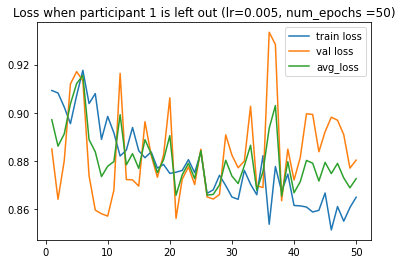

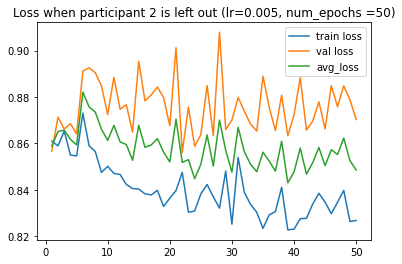

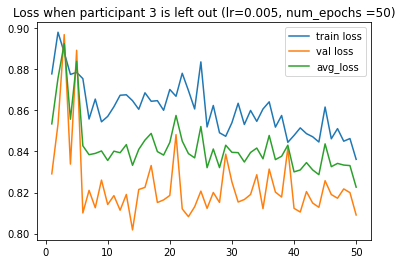

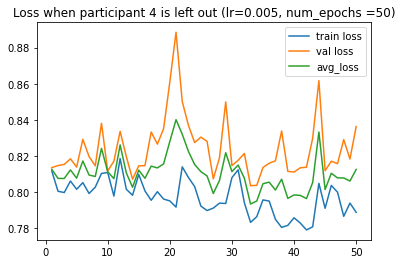

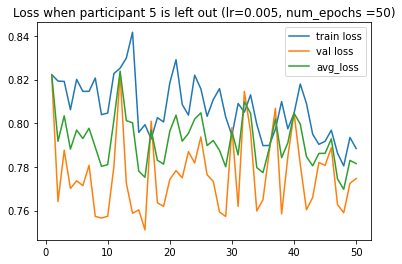

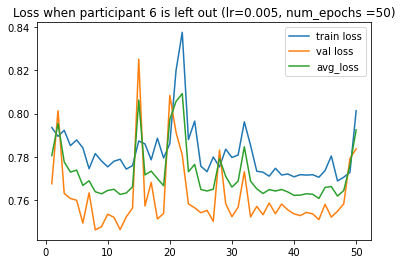

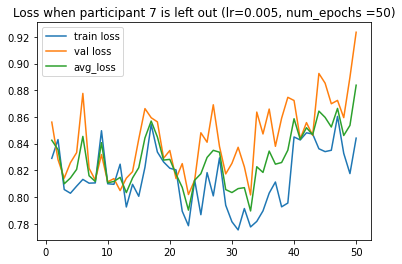

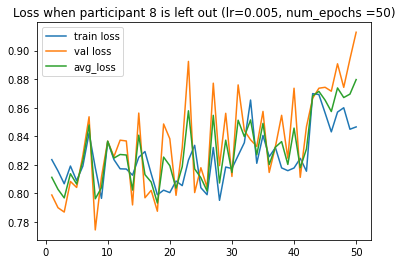

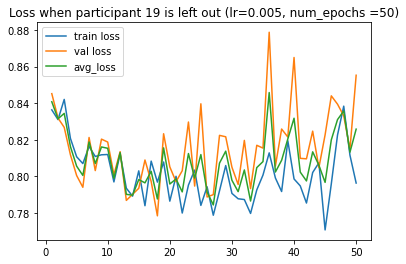

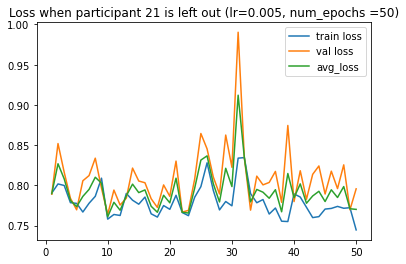

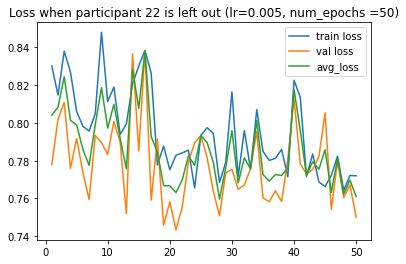

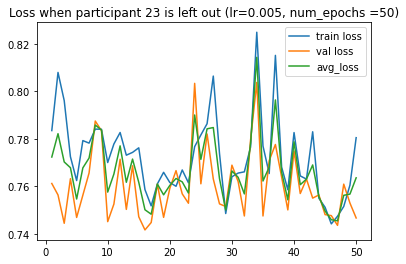

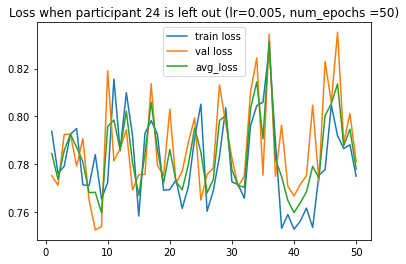

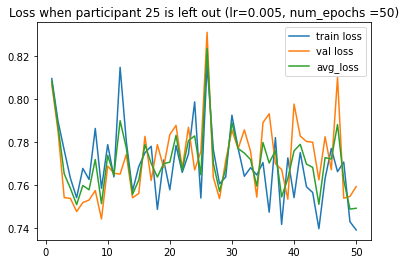

In [25]:
Linear_LOP0CV(normalised_df, model=Linear_all_features_ratings(), num_folds=3, predicting_feature='rating_level_num', learning_rate=0.005, num_epochs=50, random_state=num)
#rating_level_num


## Model 2 - Linear model using only the emg data (48 features)

In [26]:
complete_emg = normalised_df.iloc[:,:59]
complete_emg.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,subwindow_start_time,subwindow_end_time,max_ch1_Hand0,max_ch2_Hand0,max_ch3_Hand0,max_ch4_Hand0,max_ch5_Hand0,max_ch6_Hand0,max_ch7_Hand0,max_ch8_Hand0,mean_ch1_Hand0,mean_ch2_Hand0,mean_ch3_Hand0,mean_ch4_Hand0,mean_ch5_Hand0,mean_ch6_Hand0,mean_ch7_Hand0,mean_ch8_Hand0,std_ch1_Hand0,std_ch2_Hand0,std_ch3_Hand0,std_ch4_Hand0,std_ch5_Hand0,std_ch6_Hand0,std_ch7_Hand0,std_ch8_Hand0,max_ch1_Hand1,max_ch2_Hand1,max_ch3_Hand1,max_ch4_Hand1,max_ch5_Hand1,max_ch6_Hand1,max_ch7_Hand1,max_ch8_Hand1,mean_ch1_Hand1,mean_ch2_Hand1,mean_ch3_Hand1,mean_ch4_Hand1,mean_ch5_Hand1,mean_ch6_Hand1,mean_ch7_Hand1,mean_ch8_Hand1,std_ch1_Hand1,std_ch2_Hand1,std_ch3_Hand1,std_ch4_Hand1,std_ch5_Hand1,std_ch6_Hand1,std_ch7_Hand1,std_ch8_Hand1
0,7,14,3,smoothness,1,3,medium,2,1,2021-08-05 13:21:31.481,2021-08-05 13:21:32.468,0.008264,0.241026,0.351956,0.000000,0.518072,0.304812,0.5250,0.333334,0.106673,0.460704,0.603821,0.332895,0.988182,0.603340,0.956492,0.570180,-0.985256,-0.955814,-0.949743,-0.982661,-0.964160,-0.961455,-0.967675,-0.963391,0.016394,0.859156,0.514450,0.460318,-0.004082,0.991836,0.326732,0.161290,0.258945,0.997200,0.751344,0.701532,0.295330,0.458744,0.440816,0.298715,-0.960808,-0.884621,-0.614884,-0.628047,-0.987794,-0.038630,-0.536748,-0.927903
1,7,14,3,smoothness,1,3,medium,2,2,2021-08-05 13:21:32.495,2021-08-05 13:21:33.464,0.008264,0.241026,0.351956,0.000000,0.518072,0.326204,0.5125,0.333334,0.106493,0.460726,0.604258,0.332627,0.989237,0.604063,0.956428,0.569485,-0.985302,-0.955408,-0.953098,-0.982313,-0.963152,-0.960226,-0.973370,-0.963135,0.016394,0.915492,0.618498,0.492064,-0.004082,0.991836,0.366336,0.170508,0.258478,0.998128,0.752897,0.700869,0.294375,0.405040,0.441458,0.298811,-0.953791,-0.853336,-0.387693,-0.646712,-0.988134,0.290628,-0.529831,-0.897553
2,7,14,3,smoothness,1,3,medium,2,3,2021-08-05 13:21:33.513,2021-08-05 13:21:46.475,0.371900,0.456410,0.698324,0.214876,0.554216,0.401070,0.7500,0.466666,0.106607,0.460828,0.604570,0.332814,0.988206,0.603891,0.956325,0.570097,-0.929447,-0.889868,-0.848290,-0.938200,-0.967514,-0.963592,-0.951021,-0.937352,0.032786,0.873240,0.664740,0.502646,0.991836,0.991836,0.396040,0.244240,0.258554,0.997869,0.750619,0.699494,0.282343,0.422802,0.438818,0.298176,-0.961115,-0.908918,-0.668185,-0.789606,-0.765182,-0.164416,-0.668001,-0.915049
3,7,14,4,thickness,2,5,medium,2,1,2021-08-05 13:22:02.060,2021-08-05 13:22:03.029,0.024794,0.323076,0.508380,0.024794,0.518072,0.347594,0.5250,0.355556,0.106290,0.460972,0.604313,0.313160,0.987758,0.603574,0.956000,0.570496,-0.973885,-0.769312,-0.646640,-0.542316,-0.959053,-0.953471,-0.953027,-0.932237,0.032786,0.746478,0.433526,0.333334,-0.012244,-0.004082,0.287128,0.161290,0.258337,0.997686,0.750687,0.699454,0.293985,0.407644,0.433812,0.297794,-0.949808,-0.928138,-0.795144,-0.892554,-0.988841,-0.989511,-0.729222,-0.925071
4,7,14,4,thickness,2,5,medium,2,2,2021-08-05 13:22:03.061,2021-08-05 13:22:04.047,0.008264,0.271794,0.474860,1.000000,0.493976,0.304812,0.5250,0.344444,0.106242,0.460656,0.604321,0.461582,0.993944,0.603550,0.956301,0.571031,-0.978222,-0.882761,-0.812289,-0.244749,-0.955828,-0.965656,-0.957653,-0.939841,0.024590,0.732394,0.421966,0.301588,-0.004082,-0.004082,0.445544,0.198156,0.258541,0.998229,0.750420,0.698867,0.294158,0.407857,0.434614,0.298768,-0.957735,-0.944408,-0.865208,-0.904641,-0.988516,-0.990637,-0.448829,-0.896786


### Create the model

In [27]:
class Linear_emg_features_properties(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(48, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 5)        
           
    def forward(self, x): #, x2
        #print(x.shape)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class Linear_emg_features_ratings(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(48+5, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 3)        

    def forward(self, x): #, x2
        #print(x.shape)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x


In [28]:
complete_emg.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,subwindow_start_time,subwindow_end_time,max_ch1_Hand0,max_ch2_Hand0,max_ch3_Hand0,max_ch4_Hand0,max_ch5_Hand0,max_ch6_Hand0,max_ch7_Hand0,max_ch8_Hand0,mean_ch1_Hand0,mean_ch2_Hand0,mean_ch3_Hand0,mean_ch4_Hand0,mean_ch5_Hand0,mean_ch6_Hand0,mean_ch7_Hand0,mean_ch8_Hand0,std_ch1_Hand0,std_ch2_Hand0,std_ch3_Hand0,std_ch4_Hand0,std_ch5_Hand0,std_ch6_Hand0,std_ch7_Hand0,std_ch8_Hand0,max_ch1_Hand1,max_ch2_Hand1,max_ch3_Hand1,max_ch4_Hand1,max_ch5_Hand1,max_ch6_Hand1,max_ch7_Hand1,max_ch8_Hand1,mean_ch1_Hand1,mean_ch2_Hand1,mean_ch3_Hand1,mean_ch4_Hand1,mean_ch5_Hand1,mean_ch6_Hand1,mean_ch7_Hand1,mean_ch8_Hand1,std_ch1_Hand1,std_ch2_Hand1,std_ch3_Hand1,std_ch4_Hand1,std_ch5_Hand1,std_ch6_Hand1,std_ch7_Hand1,std_ch8_Hand1
0,7,14,3,smoothness,1,3,medium,2,1,2021-08-05 13:21:31.481,2021-08-05 13:21:32.468,0.008264,0.241026,0.351956,0.000000,0.518072,0.304812,0.5250,0.333334,0.106673,0.460704,0.603821,0.332895,0.988182,0.603340,0.956492,0.570180,-0.985256,-0.955814,-0.949743,-0.982661,-0.964160,-0.961455,-0.967675,-0.963391,0.016394,0.859156,0.514450,0.460318,-0.004082,0.991836,0.326732,0.161290,0.258945,0.997200,0.751344,0.701532,0.295330,0.458744,0.440816,0.298715,-0.960808,-0.884621,-0.614884,-0.628047,-0.987794,-0.038630,-0.536748,-0.927903
1,7,14,3,smoothness,1,3,medium,2,2,2021-08-05 13:21:32.495,2021-08-05 13:21:33.464,0.008264,0.241026,0.351956,0.000000,0.518072,0.326204,0.5125,0.333334,0.106493,0.460726,0.604258,0.332627,0.989237,0.604063,0.956428,0.569485,-0.985302,-0.955408,-0.953098,-0.982313,-0.963152,-0.960226,-0.973370,-0.963135,0.016394,0.915492,0.618498,0.492064,-0.004082,0.991836,0.366336,0.170508,0.258478,0.998128,0.752897,0.700869,0.294375,0.405040,0.441458,0.298811,-0.953791,-0.853336,-0.387693,-0.646712,-0.988134,0.290628,-0.529831,-0.897553
2,7,14,3,smoothness,1,3,medium,2,3,2021-08-05 13:21:33.513,2021-08-05 13:21:46.475,0.371900,0.456410,0.698324,0.214876,0.554216,0.401070,0.7500,0.466666,0.106607,0.460828,0.604570,0.332814,0.988206,0.603891,0.956325,0.570097,-0.929447,-0.889868,-0.848290,-0.938200,-0.967514,-0.963592,-0.951021,-0.937352,0.032786,0.873240,0.664740,0.502646,0.991836,0.991836,0.396040,0.244240,0.258554,0.997869,0.750619,0.699494,0.282343,0.422802,0.438818,0.298176,-0.961115,-0.908918,-0.668185,-0.789606,-0.765182,-0.164416,-0.668001,-0.915049
3,7,14,4,thickness,2,5,medium,2,1,2021-08-05 13:22:02.060,2021-08-05 13:22:03.029,0.024794,0.323076,0.508380,0.024794,0.518072,0.347594,0.5250,0.355556,0.106290,0.460972,0.604313,0.313160,0.987758,0.603574,0.956000,0.570496,-0.973885,-0.769312,-0.646640,-0.542316,-0.959053,-0.953471,-0.953027,-0.932237,0.032786,0.746478,0.433526,0.333334,-0.012244,-0.004082,0.287128,0.161290,0.258337,0.997686,0.750687,0.699454,0.293985,0.407644,0.433812,0.297794,-0.949808,-0.928138,-0.795144,-0.892554,-0.988841,-0.989511,-0.729222,-0.925071
4,7,14,4,thickness,2,5,medium,2,2,2021-08-05 13:22:03.061,2021-08-05 13:22:04.047,0.008264,0.271794,0.474860,1.000000,0.493976,0.304812,0.5250,0.344444,0.106242,0.460656,0.604321,0.461582,0.993944,0.603550,0.956301,0.571031,-0.978222,-0.882761,-0.812289,-0.244749,-0.955828,-0.965656,-0.957653,-0.939841,0.024590,0.732394,0.421966,0.301588,-0.004082,-0.004082,0.445544,0.198156,0.258541,0.998229,0.750420,0.698867,0.294158,0.407857,0.434614,0.298768,-0.957735,-0.944408,-0.865208,-0.904641,-0.988516,-0.990637,-0.448829,-0.896786


### Run the model for properties

In [29]:
#Linear_LOP0CV(complete_emg, model=Linear_emg_features_properties(), num_folds=3, predicting_feature='property_id', learning_rate=0.005, num_epochs=50, random_state=num)


### Run the model for ratings

LEAVING PARTICIPANT 1 OUT:
FOLD 1:
epoch 1: train loss = 1.04, val loss = 1.05, average loss = 1.04
epoch 11: train loss = 0.99, val loss = 1.04, average loss = 1.01
epoch 21: train loss = 0.96, val loss = 1.01, average loss = 0.98
epoch 31: train loss = 0.95, val loss = 1.01, average loss = 0.98
epoch 41: train loss = 0.93, val loss = 0.99, average loss = 0.96
FOLD 2:
epoch 1: train loss = 0.97, val loss = 0.91, average loss = 0.94
epoch 11: train loss = 0.95, val loss = 0.9, average loss = 0.92
epoch 21: train loss = 0.94, val loss = 0.92, average loss = 0.93
epoch 31: train loss = 0.94, val loss = 0.9, average loss = 0.92
epoch 41: train loss = 0.93, val loss = 0.91, average loss = 0.92
FOLD 3:
epoch 1: train loss = 0.92, val loss = 0.91, average loss = 0.92
epoch 11: train loss = 0.9, val loss = 0.92, average loss = 0.91
epoch 21: train loss = 0.9, val loss = 0.92, average loss = 0.91
epoch 31: train loss = 0.89, val loss = 0.93, average loss = 0.91
epoch 41: train loss = 0.88, val

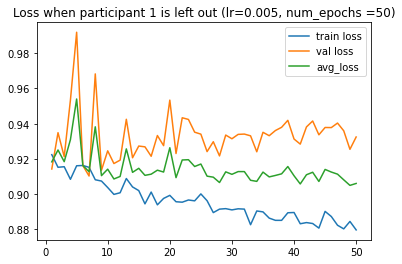

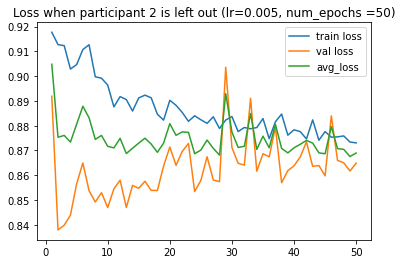

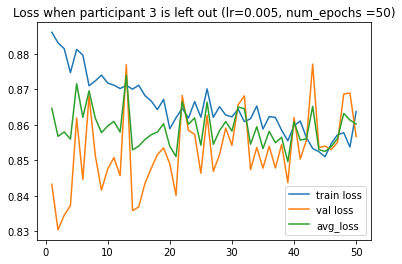

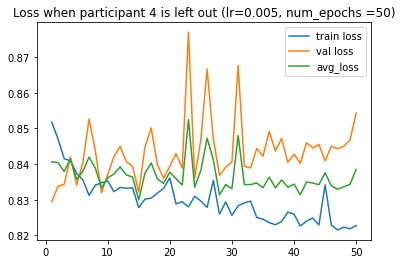

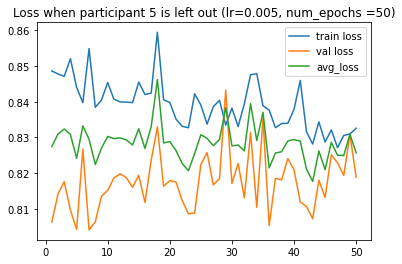

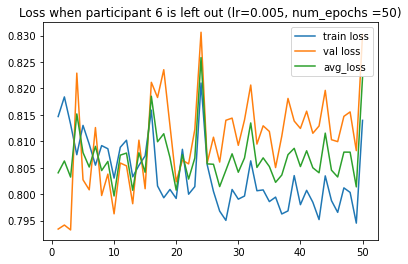

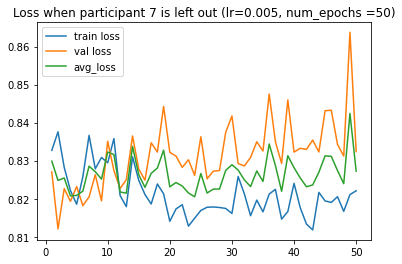

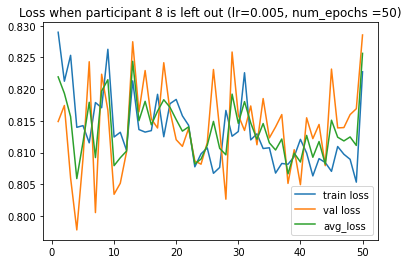

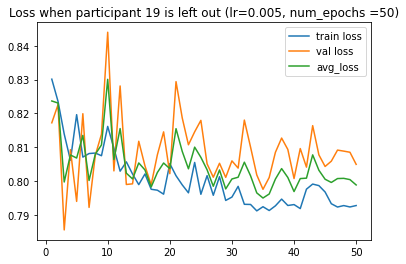

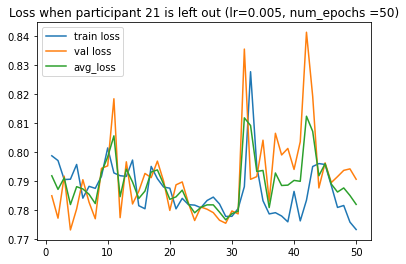

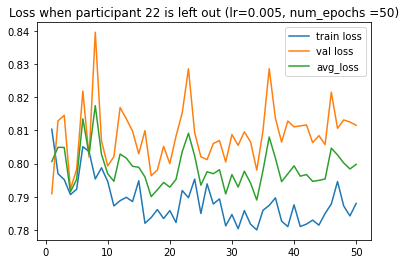

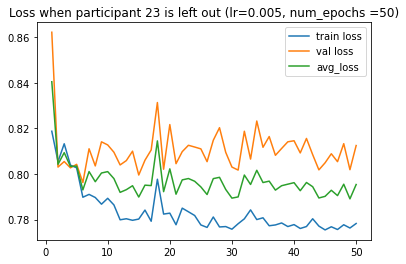

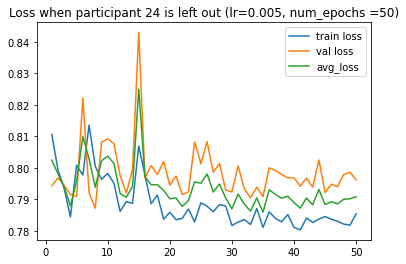

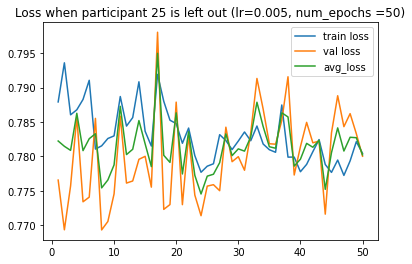

In [30]:
Linear_LOP0CV(complete_emg, model=Linear_emg_features_ratings(), num_folds=3, predicting_feature='rating_level_num', learning_rate=0.005, num_epochs=50, random_state=num)
     

In [31]:
xdfgchvjbkn

NameError: name 'xdfgchvjbkn' is not defined

## Model 3 - LSTM + fully connected layers using all 180 features

In [ ]:
fcygvhbkjln

In [ ]:
hand_0.head(2)

In [ ]:
#hand_0.new_interaction_id.unique().tolist()#hand_0.iloc[:,11:].shape[1]#.slice_num.nunique()

In [ ]:
itr_id_df = hand_0[hand_0.new_interaction_id==1] 
itr_id_df.iloc[0,11:].values

In [ ]:
df_info = normalised_df.iloc[:,:11]
hand1_emg = normalised_df.iloc[:,35:59]
a = pd.concat([df_info, hand1_emg], axis=1)
print(a.shape)
b = normalised_df.iloc[:,:35]
print(b.shape)

In [ ]:
df_info.head(2)

In [ ]:
b.head(2)

complete_emg = normalised_df.iloc[:,:59]
hand0_emg = normalised_df.iloc[:,35:59]
hand0_emg.head()

In [ ]:
# Add a column to interact

normalised_df.insert(5, "new_interaction_id", None)
normalised_df['new_interaction_id'] = normalised_df.groupby(['participant_id', 'clothes_id', 'property_id', 'sub_window_num'], sort=False).ngroup() + 1
normalised_df.head()


In [ ]:
# Obtain features for each hand
hand1_emg = normalised_df.iloc[:,35:59]

hand0_acc = normalised_df.iloc[:,59:86]
hand1_acc = normalised_df.iloc[:,86:113]

hand0_qua = normalised_df.iloc[:,113:152]
hand1_qua = normalised_df.iloc[:,152:]

df_info = normalised_df.iloc[:,:11]
# Combine the data to ceate a df for each hand
emg_0 = normalised_df.iloc[:,:35]
emg_1 = pd.concat([df_info, hand1_emg], axis=1)

hand_0 = pd.concat([emg_0, hand0_acc, hand0_qua], axis=1)
hand_1 = pd.concat([df_info, hand1_emg, hand1_acc, hand1_qua], axis=1)

In [ ]:
print(hand_0.shape)
print(hand_1.shape)

print(emg_0.shape)
print(emg_1.shape)


### Create the model

In [ ]:
class LSTM_all_features_properties(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(90, 40, 1, batch_first=True)
        self.fc1 = nn.Linear(3 * 40 * 2, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
class LSTM_all_features_ratings(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(90+5, 40, 1, batch_first=True)
        self.fc1 = nn.Linear(3 * 40 * 2, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 3)
          
    def forward(self, x1, x2): #, x2
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    


In [ ]:
def find_best_model_for_3d_X(train_dataloader, val_dataloader, learning_rate, num_epochs, model):

    # Model
    train_model = model

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))

            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
     
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,3)}, val loss = {round(avg_validation_loss,3)}, average loss = {round(avg_loss,3)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def LSTM_LOP0CV(data_0, data_1, model, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
        
    total_conf_mat = 0
    micro_f1_lst = []
    acc_lst = []
    if predicting_feature == 'property_id':
        macro_f1_lst = []
    elif predicting_feature == 'rating_level_num':
        weighted_f1_lst = [] 
        
        data0_add = create_y_train_for_2d_X(data_0, predicting_feature = 'property_id', output_as_tensor='No')
        data0_add_pd = pd.DataFrame(data0_add, columns = ['smoothness','thickness','warmth', 'flexibility', 'softness'])
        data_0 = pd.concat([data_0.reset_index(drop=True), data0_add_pd.reset_index(drop=True)], axis=1)
        data1_add = create_y_train_for_2d_X(data_1, predicting_feature = 'property_id', output_as_tensor='No')
        data1_add_pd = pd.DataFrame(data1_add, columns = ['smoothness','thickness','warmth', 'flexibility', 'softness'])
        data_1 = pd.concat([data_1.reset_index(drop=True), data1_add_pd.reset_index(drop=True)], axis=1)
    
    for participant in sorted(data_0.participant_id.unique()): # # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11) 
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)           
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = predicting_feature)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = predicting_feature)        
 

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=y_test.shape[0]//4) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_3d_X(train_dataloader, val_dataloader, learning_rate, num_epochs, model)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = model
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()    
        
        if predicting_feature == 'property_id':
            conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
            macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
            macro_f1_lst.append(macro_f1_score) 
        elif predicting_feature == 'rating_level_num':
            conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0,1,2])
            weighted_f1_score = f1_score(test_labels_np, test_predicted_np, average='weighted') 
            weighted_f1_lst.append(weighted_f1_score)
            
        total_conf_mat += conf_mat
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        micro_f1_lst.append(micro_f1_score)
        acc = accuracy_score(test_labels_np, test_predicted_np)
        acc_lst.append(acc)


        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        if predicting_feature == 'property_id':
            print(f"(3) Macro F1 score = {round(macro_f1_score,2)}")
        elif predicting_feature == 'rating_level_num':
            print(f"(3) Weighted F1 score = {round(weighted_f1_score,2)}")            
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    if predicting_feature == 'property_id':
        avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)  
    elif predicting_feature == 'rating_level_num':
        avg_weighted_f1_score = sum(weighted_f1_lst) / len(weighted_f1_lst)             
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    if predicting_feature == 'property_id':
        print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    elif predicting_feature == 'rating_level_num':
        print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            


### Run the model for properties

In [ ]:
LSTM_LOP0CV(hand_0, hand_1, model=LSTM_all_features_properties(), num_folds=5, predicting_feature='property_id', learning_rate=0.085, num_epochs=50, random_state=num) #, num_inner_folds=5


### Run the model for ratings

In [ ]:
LSTM_LOP0CV(hand_0, hand_1, model=LSTM_all_features_ratings(), num_folds=5, predicting_feature='rating_level_num', learning_rate=0.005, num_epochs=50, random_state=num) #, num_inner_folds=5


## Model 4 - LSTM + fully connected layers using only the emg data (48 features)

complete_emg = normalised_df.iloc[:,:59]
hand0_emg = normalised_df.iloc[:,35:59]
hand0_emg.head()

In [ ]:
#hand0_emg = normalised_df.iloc[:,19:27]
hand1_emg = normalised_df.iloc[:,35:59]

emg_0 = normalised_df.iloc[:,:35]
emg_1 = pd.concat([df_info, hand1_emg], axis=1)


### Create the model

In [ ]:
class LSTM_emg_features_properties(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(24, 15, 1, batch_first=True)
        self.fc1 = nn.Linear(3 * 15 * 2, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
class LSTM_emg_features_ratings(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(24+5, 15, 1, batch_first=True)
        self.fc1 = nn.Linear(3 * 15 * 2, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 3)
          
    def forward(self, x1, x2): #, x2
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

### Run the model

In [ ]:
LSTM_LOP0CV(emg_0, emg_1, model=LSTM_emg_features_properties(), num_folds=5, predicting_feature='property_id', learning_rate=0.005, num_epochs=70, random_state=num) #, num_inner_folds=5



### Run the model for ratings

In [ ]:
LSTM_LOP0CV(emg_0, emg_1, model=LSTM_emg_features_ratings(), num_folds=5, predicting_feature='rating_level_num', learning_rate=0.005, num_epochs=70, random_state=num) #, num_inner_folds=5


In [ ]:
dtryftugyihuoi

In [ ]:
def find_best_model_for_fold_4(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = LSTM_2()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        #print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def LSTM_LOP0CV_properties_2(data_0, data_1, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    #lst = [6,24,2]#,24]
    
    for participant in sorted(data_0.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11)        
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = 'property_id')
        #print(y_test)

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=30) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_4(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = LSTM_2()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            



In [ ]:
LSTM_LOP0CV_properties_2(emg_0, emg_1, num_folds=5, predicting_feature='property_id', learning_rate=0.05, num_epochs=70, random_state=num) 


In [ ]:
t2 = time.time()

## Model 5 - CNN + LSTM

In [ ]:
complete_emg = normalised_df.iloc[:,:59]
hand0_emg = normalised_df.iloc[:,43:51]
hand0_emg.head()

In [ ]:
hand0_emg = normalised_df.iloc[:,19:27]
hand1_emg = normalised_df.iloc[:,43:51]

emg_0 = pd.concat([df_info, hand0_emg], axis=1)
emg_1 = pd.concat([df_info, hand1_emg], axis=1)


### Create the model

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0, groups=3) # Change kernel size to 3
        self.pool = nn.MaxPool1d(1, 1) # Change kernel size to 1 and stride to 1
        self.rnn = nn.LSTM(8, 4, 1, batch_first=True)
        #self.h0 = torch.randn(1, 50, 7)
        #self.c0 = torch.randn(1, 50, 7)
        self.fc1 = nn.Linear(3 * 4 * 2, 18)
        self.fc2 = nn.Linear(18, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        x1 = self.pool(F.tanh(self.conv1(x1))) # Use tanh instead?
        x2 = self.pool(F.tanh(self.conv1(x2))) # Use tanh instead?
        
        #x = self.pool(F.relu(self.conv2(x)))
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [ ]:
m3 = CNN_LSTM()
print(m3)

In [ ]:
def find_best_model_for_fold_3(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = CNN_LSTM()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def CNN_LSTM_LOP0CV_properties_1(data_0, data_1, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    lst = [6,24,2]#,24]
    
    for participant in lst: #sorted(data0.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11)        
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = 'property_id')
        #print(y_test)

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=30) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_3(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = CNN_LSTM()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            



### Run the model

In [ ]:
CNN_LSTM_LOP0CV_properties_1(emg_0, emg_1, num_folds=5, predicting_feature='property_id', learning_rate=0.3, num_epochs=30, random_state=num) 



In [ ]:
CNN_LSTM_LOP0CV_properties_1(emg_0, emg_1, num_folds=5, predicting_feature='property_id', learning_rate=0.3, num_epochs=30, random_state=num) 


In [ ]:
t2 = time.time()

In [ ]:
def find_best_model_for_fold_2(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = Linear_model_2()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1) #, train_input2
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        #print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def Linear_LOP0CV_properties_2(data, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num, X_dim=2): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    #lst = [6,24,2]#,24]
    
    for participant in sorted(data.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data = data[data.participant_id != participant] 
        testing_data = data[data.participant_id == participant] 

        # Data preparation
        if X_dim == 2:
            X_train = create_X_2d(training_data, 11)       
            y_train = create_y_train_for_2d_X(training_data, predicting_feature = 'property_id')
            X_test = create_X_2d(testing_data, 11) 
            y_test = create_y_test_for_2d_X(testing_data, predicting_feature = 'property_id')
        elif X_dim == 3:
            X_train = create_X_3d(training_data, 11)       
            y_train = create_y_train_for_3d_X(training_data, predicting_feature = 'property_id')
            X_test = create_X_3d(testing_data, 11) 
            y_test = create_y_test_for_3d_X(testing_data, predicting_feature = 'property_id')

        #print(X_train.shape)
        #print(y_train.shape)
        #print(X_test.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train, y_train) 
        
        test_dataset = TensorDataset(X_test, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=90) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_2(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = Linear_model_2()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            

